# REMclust
---
### Introduction

REMclust is a python package for model-based clustering based on finite normal mixture modelling. It uses a peak finding criterion to find modes within the data set. An initial mode set is taken to be the means in Gaussian components.

Once the initial mode set has been selected, an iterative procedure comprising two blocks are triggered. A mixture is produced for each iteration.
1. An EM block to fit the covariances and mixing proportions of the components
2. A pruning block to remove one of the components, as part of an efficient model selection strategy.

Additional functionalities are available for displaying and visualizing fitted models along with clustering results.

---
### Data

The data set used in this vignette is the [Palmer Archipelago (Antarctica) Penguin Data](https://github.com/allisonhorst/palmerpenguins). The following methods are used simply to load the dataset. In this particular data set, the features are measured across different scales, for example, culmen depth ranges from 13.1 to 21.5, while body mass ranges from 2700 to 6300. This difference in scale can negatively impact the clustering accuracy, so standardisation was performed. Standardisation ensures that all features are measured in comparable scales, and is process that is recommended when that data set that is being clustered has features that vary widely in scale.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from REM import REM
from sklearn import preprocessing


In [3]:
data = np.genfromtxt('Data/penguin.csv', delimiter=",")
x = data[:, 1:]
y = data[:, 0]
labels = ['Culmen Length', 'Culmen Depth', 'Flipper Length', 'Body Mass', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']
x = x[1:,:]
scaler = preprocessing.StandardScaler().fit(x)
x = scaler.transform(x)

n_samples, n_features = x.shape

In [12]:
def plot_data_for_exploration(dimensions, data):
    fig, axs = plt.subplots(dimensions, dimensions, figsize=(15, 8))
    for i in range(dimensions):
        for j in range(dimensions):
            if i != j:
                axs[j][i].scatter(data[:,i], data[:,j], s=5)
            else:
                axs[i][i].scatter(data[:, i], data[:, i], marker="none")
                axs[i][i].text(0.5, 0.5, labels[i], horizontalalignment="center", verticalalignment="center",
                transform=axs[i][i].transAxes, fontsize=10)
    for ax in fig.get_axes():
        ax.label_outer()
                

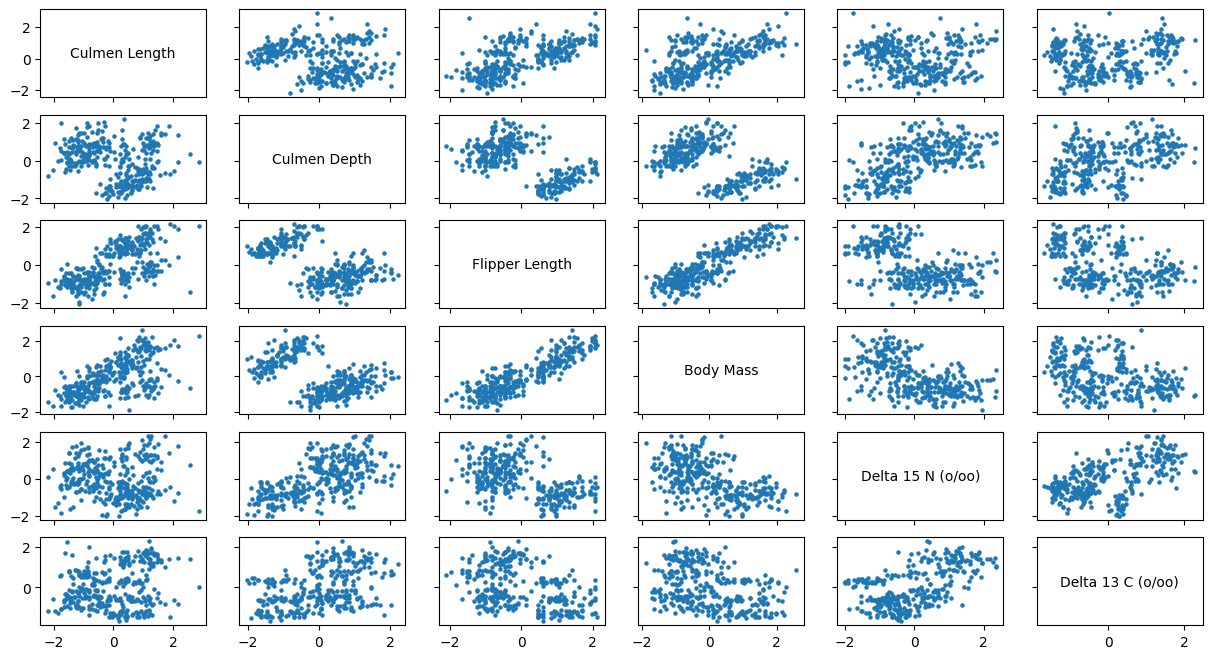

In [13]:
plot_data_for_exploration(n_features, x)

### Initialisation
The first step in applying REM to the data set is to initialise an REM object.
```python
REM(data, covariance_type='full', criteria='all', bandwidth='diagonal', tol=1e-3, reg_covar=1e-6, max_iter=100)
```
- **data (array-like of shape (n_samples, n_features))**: The data the model is being fitted to.
- **covariance_type {'full', 'tied', 'diag', 'spherical'}**: A string describing the type of covariance parameters to use. ‘full’: each component has its own general covariance matrix. ‘tied’: all components share the same general covariance matrix. ‘diag’: each component has its own diagonal covariance matrix. ‘spherical’: each component has its own single variance.
- **criteria {'all', 'aic', 'bic', 'icl'}**: A string defining the criterion score used in model selection. At the end of each iteration of REM, a mixture is produced. The mixture minimises this score will be taken as the optimal clustering.
- **bandwidth ({'diagonal', 'spherical', 'normal_reference'}, int, float)**: Either a string, integer, or floating point number that defines the bandwidth used when finding the modes.
- **tol (float)**: The convergence threshold. EM iterations will stop when the lower bound average gain is below this threshold.
- **reg_covar (float)**: Non-negative regularization added to the diagonal of covariance. Allows to assure that the covariance matrices are all positive.
- **max_iter (int)**: The number of EM iterations to perform.

In [4]:
bndwk = int(np.floor(np.min((30, np.log(n_samples)))))
cluster = REM.REM(data=x, covariance_type="full", criteria="icl",bandwidth=bndwk, tol=1e-4)

### Mode Selection

The initial mode set must be selected by the user. To do this, they must select a *distance_threshold* and *density_threshold*. To aid in this, the method
```python
REM.exemplars_plot()
```
is provided. This draws two plots, one is a plot of the distance between a point to its nearest neighbor with a higher density against the points' density. This plot will allow the user to select the appropriate thresholds. The ideal modes have both a high distance and density. The second plot shows the product of the distance and the density for each point, allowing the user to clearly the likely number of modes.

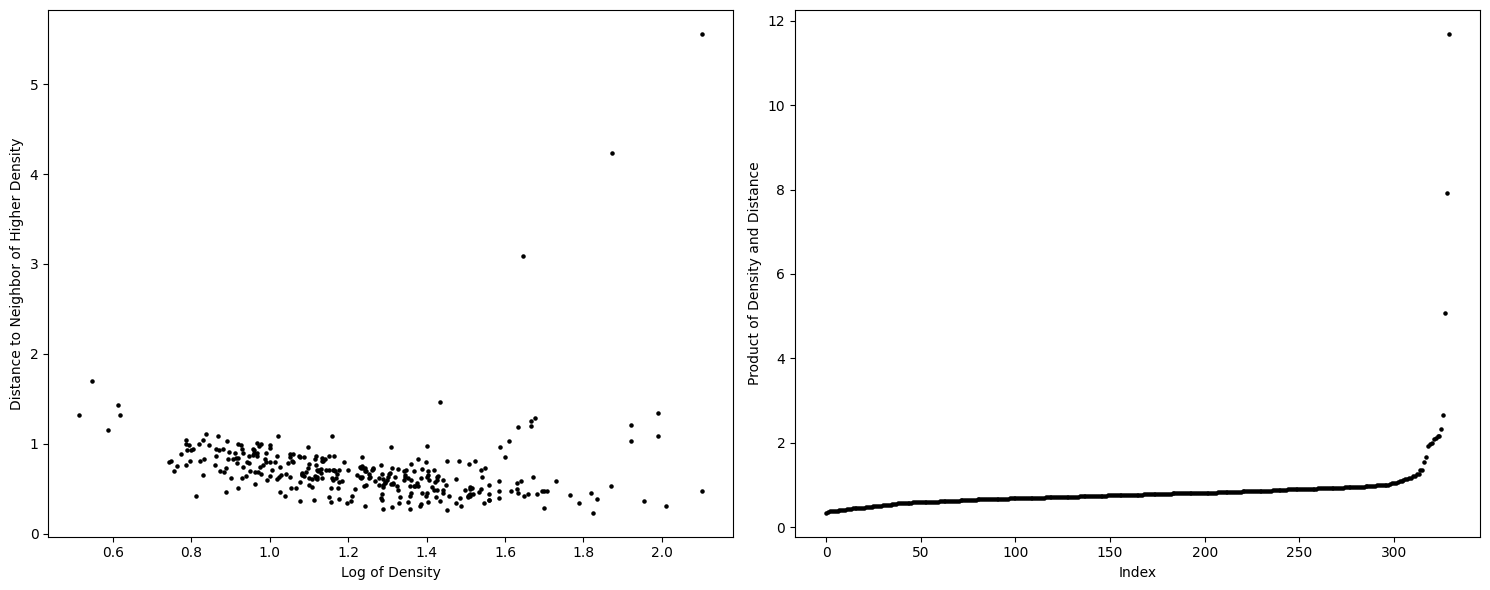

In [5]:
cluster.exemplars_plot()

REMclust also provides the method:
```python
REM.density_plot(dimensions=None, axis_labels=None)
```
- **dimensions (list(int))**: A list of integers that defines the features that will be plotted. If left as None all features will be plotted.
- **axis_labels (list(str))**: A list of strings that define the labels for the axes.

This provides a contour plot of the estimated KDE densities.

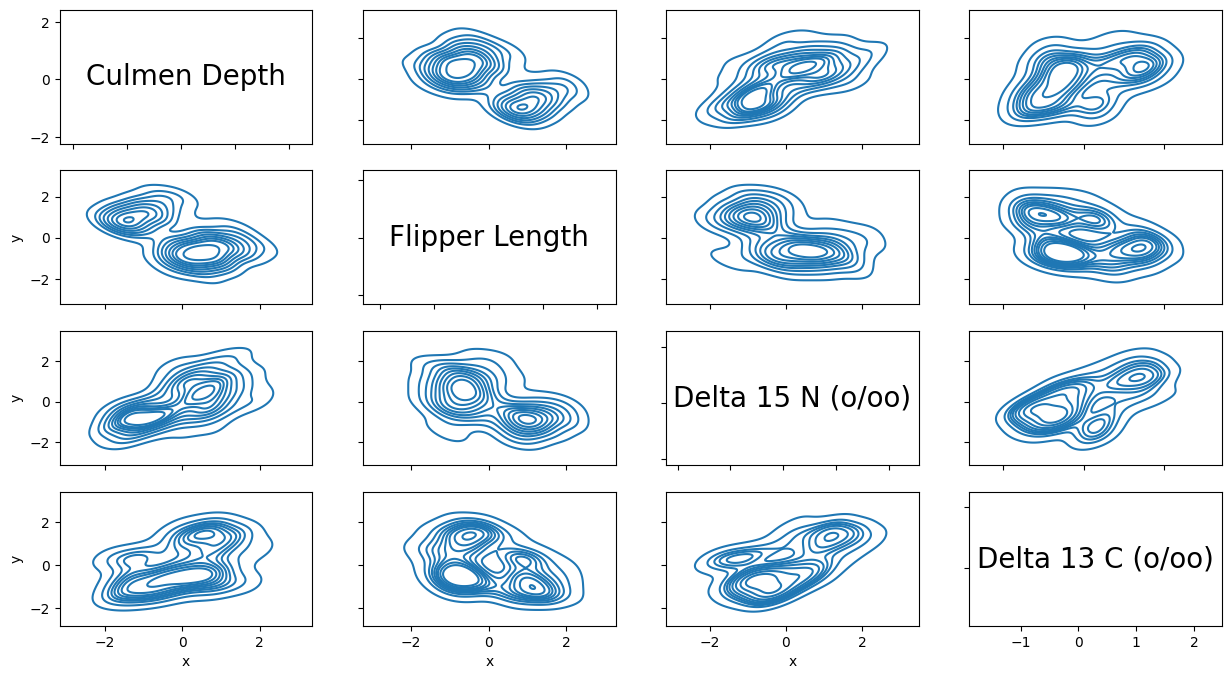

In [20]:
cluster.density_plot(dimensions=[1, 2, 4, 5], axis_labels=[labels[1], labels[2], labels[4], labels[5]])

### Clustering

To perform clustering, the following method is run:
```python
fit(max_components=5, density_threshold=None, distance_threshold=None)
```
- **max_components (int)**: An integer that defines the initial size of the mode set. The modes with the highest $density \times distance$ will fill the set.
- **density_threshold (float)**: A float that defines the threshold for the mode's density. A mode must have a higher density to be included in the initial mode set.
- **distance_threshold (float)**: A float that defines the threshold for the mode's distance. A mode must have a higher distance to be included in the initial mode set.

**Note:** There are two possible ways to define the mode set:
1. Setting the max components value k, in which the k modes with the highest $density \times distance$ will be included in the initial mode set.
2. Setting the two thresholds, in which the modes that exceed both thresholds will be included in the initial mode set.

Should the user set the max components and the thresholds, the mode set created by the thresholds will be preferred.

In [6]:
cluster.fit(distance_threshold=2, density_threshold=0.003)

3 means selected.


### Visualisation

REMclust provides visualisation tools that allow the user to explore results of the clustering. The first of these is:
```python
REM.classification_plot(mixture_selection='', dimensions=None, axis_labels=None)
```
A plot of the classification of the data that the clustering was performed on.
- **mixture_selection {'', 'aic', bic', 'icl'}** This defines whether the user would like plot the results from the model selected by AIC, BIC, or ICL. If the initial criterion was set to 'all', this is required, otherwise it should not be set.
- **dimensions (list(int))**: A list of integers that defines the features that will be plotted. If left as None all features will be plotted.
- **axis_labels (list(str))**: A list of strings that define the labels for the axes.

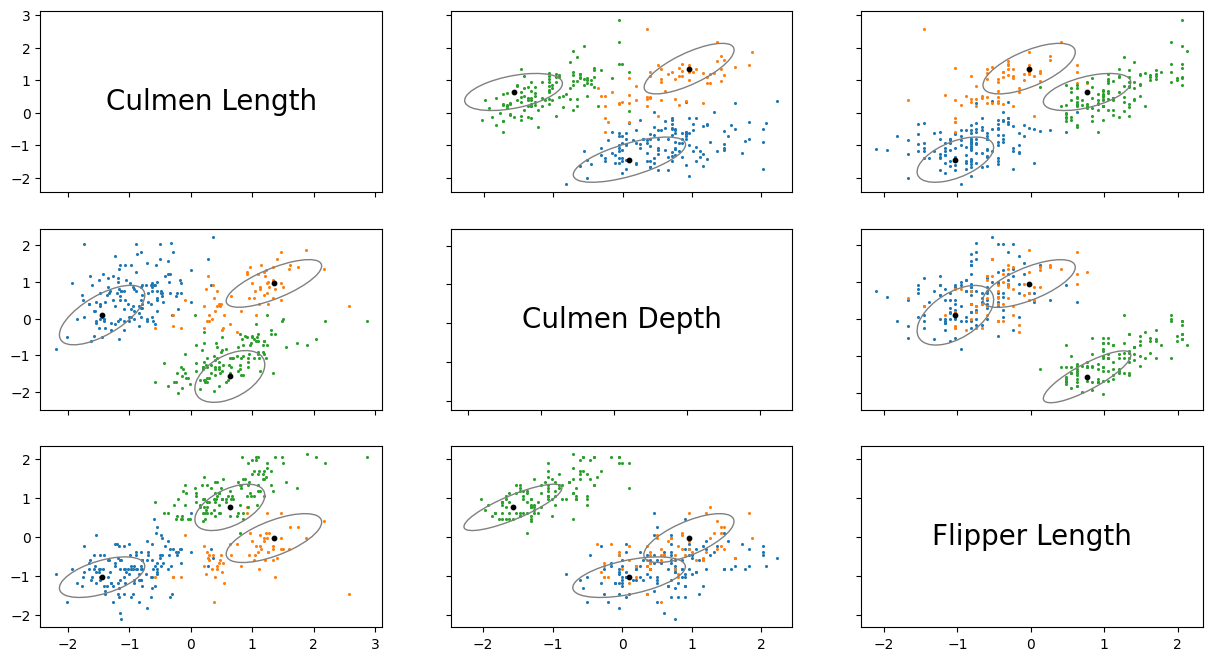

In [7]:
cluster.classification_plot(dimensions=[0,1,2], axis_labels=[labels[0], labels[1], labels[2]])

Another visualisation method provided by REMclust is:
```python
REM.uncertainty_plot(mixture_selection='', dimensions=None, axis_labels=None)
```
A plot of the uncertainty of the data that the clustering was performed on. Uncertainty measured as inverse of the difference between probability that a point belongs to the cluster it was assigned and the probability that it belongs to the next most likely cluster. The uncertainty score for a point is represented by its size in the scatter plot
- **mixture_selection {'', 'aic', bic', 'icl'}** This defines whether the user would like plot the results from the model selected by AIC, BIC, or ICL. If the initial criterion was set to 'all', this is required, otherwise it should not be set.
- **dimensions (list(int))**: A list of integers that defines the features that will be plotted. If left as None all features will be plotted.
- **axis_labels (list(str))**: A list of strings that define the labels for the axes.

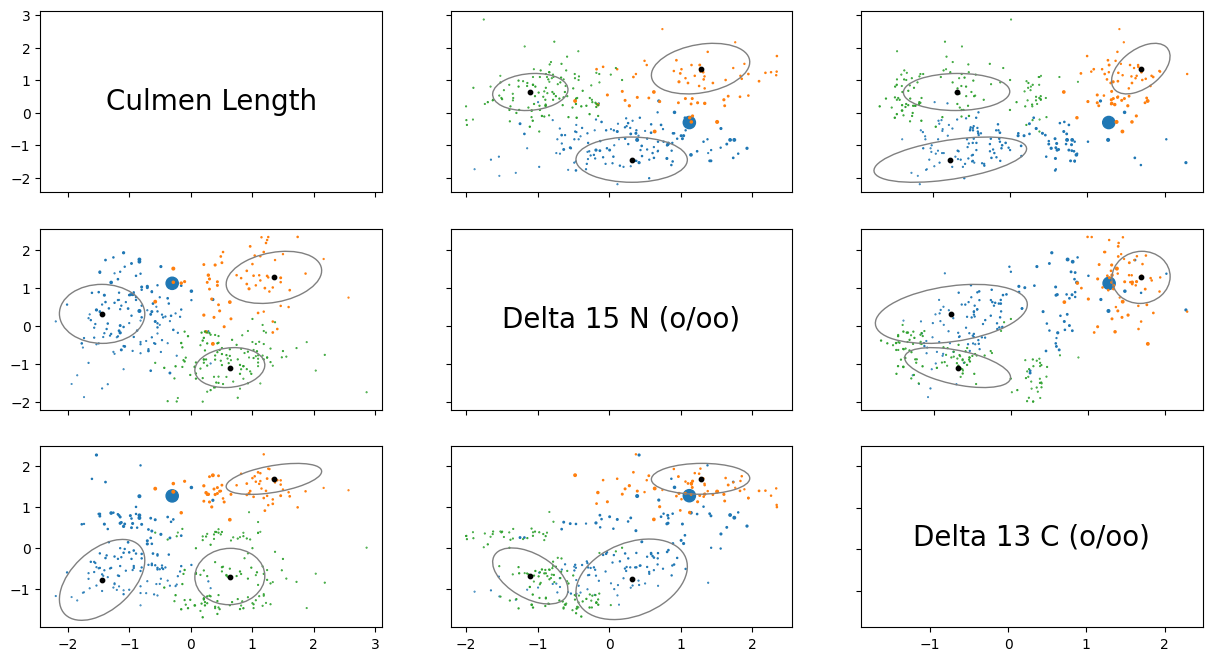

In [8]:
cluster.uncertainty_plot(dimensions=[0,4,5], axis_labels=[labels[0], labels[4], labels[5]])

Finally, REMclust provides:
```python
REM.criterion_plot()
```
A plot of the criterion scores for the different models fit

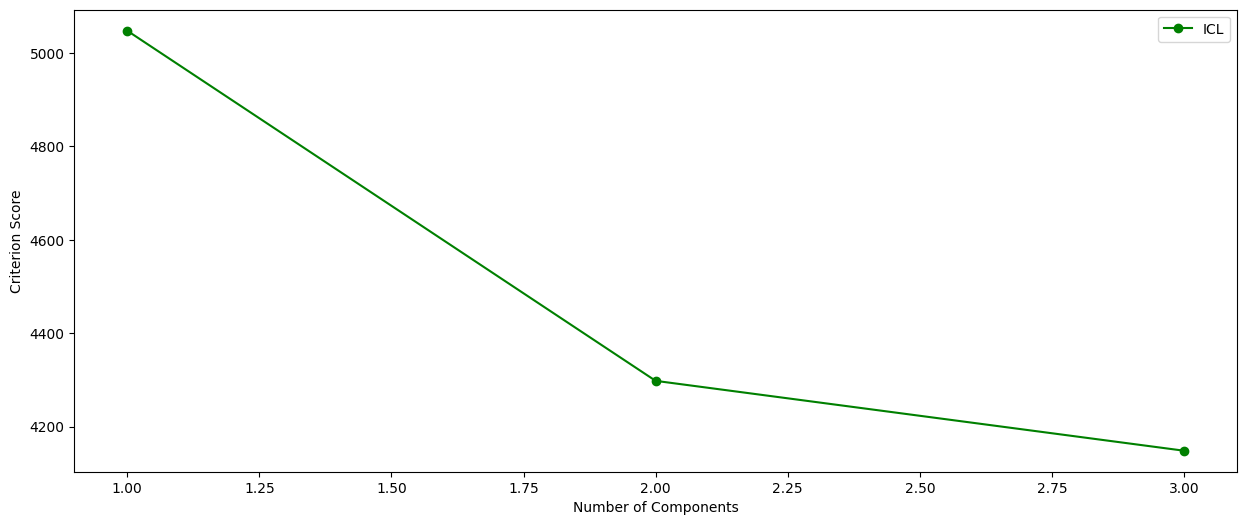

In [9]:
cluster.criterion_plot()

### Summary
As well as visualisations, REMclust also provides a method that prints text based summaries of the clustering results.
```python
REM.summary(parameters=False, classification=False, criterion_scores=False)
```
- **parameters (boolean)**: If TRUE, the parameters of mixture components are printed.
- **classification (boolean)**: If TRUE, a table of classifications/clustering of observations is printed.
- **criterion_scores (boolean)**: If TRUE, the criterion scores of all the models tested are printed.

In [10]:
cluster.summary(parameters=True, classification=True, criterion_scores=True)

ICL scores:
Number of components      ICL            
1                         5047.430917914943
2                         4297.94941510035
3                         4148.377773911351

REM full model with 3 components.

Log-Likelihood            n     ICL            
-5.557734230801972        330   5047.430917914943

Clustering Table:
   0   1   2
 142  66 122

Mixing proportions:
                     0                     1                     2
    0.4298003096720814   0.20016916200970244   0.37003052831821626

Means:
                                        [,0]                  [,1]                  [,2]                  [,3]                  [,4]                  [,5]
                  [0,]   -1.4428802310212794   0.09847251687109626   -1.0265979344127258   -1.1391980159992219    0.3155521383966185   -0.7729366056647325
                  [1,]    1.3519480199837914    0.9589566596231957  -0.02238822512058244   -0.3306680319415391    1.2786263024434288    1.6899270286191586
        